In [92]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

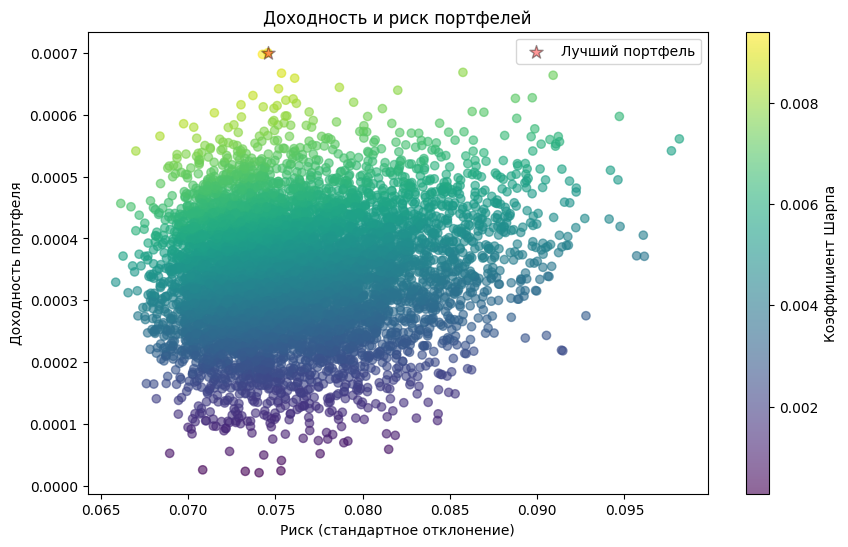

Лучшие веса: [ 84.  64.  79.  64.   9.  11.  52.  67.  87.  24.  74.  40.  99. 100.
   7. 111.  17. 108. 102.  95.  85.  71.  86.  16.  35.  70. 103.  14.
   8.  14.  82.  22.  52.  35.  27.  73.  91. 101.   8.  42.  56.  14.
  19. 113.  78.  39.  58.  10.  70. 113.  71. 114.  29. 116.  22.   0.
   8.  72.  22.  94. 112. 120.  98.  89.  24. 108.  58.  20. 104. 115.
  12.  62. 114.  39.  95. 102. 100. 107. 116.   7.  29. 114.   0.  68.
  80.   8.  29.  24.  97.  76.  99.  49.   0.  70.  29.  23.   6.  76.
  34.  32.]
Лучшая доходность: 0.0007007011210206259
Риск: 0.07456805437563051
Общая стоимость портфеля: 993259.445835847


In [102]:
data = pd.read_csv('./task1/task-1-stocks.csv') 
stock_prices = data.values 

best_weights, best_return, best_risk, best_total_value = monte_carlo_optimization(stock_prices)
print("Лучшие веса:", best_weights)
print("Лучшая доходность:", best_return)
print("Риск:", best_risk)
print("Общая стоимость портфеля:", best_total_value)

In [83]:
def calculate_portfolio_metrics(weights, stock_prices):
    """
    Функция для расчёта метрик инвестиционного портфеля на основе весов акций.
    """
    portfolio_values = np.dot(stock_prices, weights)  
    portfolio_returns = (portfolio_values[1:] - portfolio_values[:-1]) / portfolio_values[:-1] 
    average_return = np.mean(portfolio_returns)
    
    n = len(portfolio_returns) 
    risk = np.sqrt(np.sum((portfolio_returns - average_return) ** 2) * n / (n - 1))
    
    portfolio_total_value = portfolio_values[-1]
    
    return average_return, portfolio_values, risk, portfolio_total_value

In [101]:
def monte_carlo(stock_prices, max_risk=0.2, max_portfolio_value=1000000, n_simulations=100000, initial_cash=1000000, rf=0.0):
    """
    Оптимизация весов для минимизации риска и максимизации доходности с помощью Монте-Карло.
    """
    num_stocks = stock_prices.shape[1]
    eps = 50000;

    accepted_weights = []
    accepted_returns = []
    accepted_risks = []
    accepted_total_values = []
    sharpe_ratios = []
    
    best_return = -np.inf
    best_weights = None
    best_risk = None
    best_total_value = None

    for _ in range(n_simulations):
        # Генерация случайных весов (количество лотов для каждой акции)
        weights = np.zeros(num_stocks)
        max_lots = np.zeros(num_stocks)

        for i in range(num_stocks):
            # Для каждой акции вычисляем максимальное количество лотов
            max_lots[i] = int(initial_cash // stock_prices[0, i])  # Максимум лотов для этой акции

            # Можно поставить ограничение на максимальное количество лотов, например 100
            max_lots[i] = min(max_lots[i], 120)  # Ограничение сверху

            # Генерация случайного числа лотов для этой акции
            if max_lots[i] > 0:
                weights[i] = np.random.randint(0, max_lots[i] + 1)  # Случайное количество лотов
            else:
                weights[i] = 0  # Если max_lots равно 0, ставим 0

        # Расчет метрик портфеля
        avg_return, _, risk, total_value = calculate_portfolio_metrics(weights, stock_prices)

        # Вычисление коэффициента Шарпа
        sharpe_ratio = (avg_return - rf) / risk if risk != 0 else 0  # Защита от деления на 0

        # Проверка, что риск не превышает заданный порог и стоимость портфеля ~ миллион
        if risk <= max_risk and total_value <= max_portfolio_value and total_value >= max_portfolio_value - eps:
            accepted_weights.append(weights)
            accepted_returns.append(avg_return)
            accepted_risks.append(risk)
            accepted_total_values.append(total_value)
            sharpe_ratios.append(sharpe_ratio)
            
            # Обновляем лучший результат
            if avg_return > best_return:
                best_return = avg_return
                best_weights = weights
                best_risk = risk
                best_total_value = total_value
    
    # Преобразуем списки в массивы для удобства
    accepted_returns = np.array(accepted_returns)
    accepted_risks = np.array(accepted_risks)
    sharpe_ratios = np.array(sharpe_ratios)

    # Отображаем график
    plt.figure(figsize=(10, 6))
    scatter = plt.scatter(accepted_risks, accepted_returns, c=sharpe_ratios, cmap='viridis', alpha=0.6)
    
    plt.scatter(best_risk, best_return, marker = '*', color = "red", alpha = 0.4, s=100, edgecolor='black', label='Лучший портфель')

    plt.title('Доходность и риск портфелей')
    plt.xlabel('Риск')
    plt.ylabel('Доходность портфеля')
    plt.colorbar(scatter, label='Коэффициент Шарпа')
    plt.legend()
    plt.show()

    # Возвращаем лучший портфель, его метрики и общую стоимость портфеля
    return best_weights, best_return, best_risk, best_total_value